In [2]:
Objective: To visualize the positive and negative reviews using TSNE with the preprocessing techniques BoW, bigram, avgw2v, 
            tfidfw2v.
            
Note: Due to memory constraints, I chose 5000 data points from the database.
Steps Followed:
1. Using the SQLite Table to read data.
2. Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
3. Changing reviews with score less than 3 to be positive and vice-versa
4. Sorting data according to ProductId in ascending order
5. Deduplication of entries
6. Checking to see how much % of data still remains
7. How many positive and negative reviews are present in our dataset?
8. Find sentences containing HTML tags
9. Removing alphanumeric,stopwords
10. Calculating positive and negative words
11. BoW technique
12. Plotted TSNE by both suggested methods:
#TSNE using 
1)By converting Sparse to dense matrix using toarray 
2)Truncated SVD(chose number of components(600) based on explained variance ratio(85% data is widespread) 
13.Preprocessing technique without removing stopwords
14.Bigram technique
15.Truncated SVD to reduce dimensions
16.TSNE for Bigram
17.Average W2V
18.TF-IDF weighted Word2Vec
#TSNE plot for Average W2V and TFIDF weighted Word2Vec
    

SyntaxError: invalid syntax (<ipython-input-2-04df3263001a>, line 1)

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
#5000 data points chosen from the database

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
print(sorted_data.shape)

(5000, 10)


In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(4986, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#print(final['Text'].head)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

In [ ]:
From above, we can conclude that there are 4178 positive reviews and 808 negative reviews.

In [12]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [13]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('beautiful'))

{'been', 'being', "weren't", "wouldn't", 'you', 'of', 'wasn', 'weren', 'ourselves', 'during', 'when', 'yours', 'mustn', 'don', 'are', 'was', 'were', "wasn't", 'against', 'after', 'on', 'over', 'should', 'these', 'have', 'which', 'and', "doesn't", 'this', 'off', 'same', 'then', "shan't", 'it', 'yourselves', 'too', 'than', "haven't", 'she', 'won', "mustn't", 'about', 'now', 'me', 'them', "didn't", 'yourself', 'very', "you'd", "hasn't", 'in', 'only', 'down', 'isn', 'do', 'again', 'there', 'if', 'your', 'as', "it's", 'ours', 'him', 'll', 'how', 'where', 'couldn', 'that', 'few', 'themselves', 'having', 'below', 'not', 'hadn', 'his', 'between', 'is', 'their', 'theirs', 'a', 'will', "that'll", 'here', 'to', 'why', 'had', 'through', 'didn', 'my', 'under', 'other', 'aren', 'can', 'am', "should've", 'm', 'before', 'those', 'doing', 'mightn', 'such', 've', 'does', 'myself', 'any', 'all', 'both', 'own', 'whom', 'what', "hadn't", "needn't", "won't", 's', "mightn't", 'doesn', 'until', 'more', 'her',

In [14]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    print(final['Text'].head)
    print(final['Text'].shape)
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                    #print("First If condition Passed")
                    if(cleaned_words.lower() not in stop):
                        #print("Word is not a stopword")
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        #print(s)
                        filtered_sentence.append(s)
                        # (final['Score'].values)[i] == 'positive': 
                        if (final['Score'].values)[i] == 1: 
                            #print("Positive word found")
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        #if(final['Score'].values)[i] == 'negative':
                        if(final['Score'].values)[i] == 0:
                            #print("Negative word found")
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #str1
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    #print(final['CleanedText'])
    #print(final.shape)
    print(final.columns.values)

    
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

#print(all_positive_words)
#print(all_negative_words)

<bound method NDFrame.head of 2546    Why is this $[...] when the same product is av...
2547    We have used the Victor fly bait for 3 seasons...
1145    I just received my shipment and could hardly w...
1146    This was a really good idea and the final prod...
2942    I'm glad my 45lb cocker/standard poodle puppy ...
2941    We have been using this food for about 6 month...
1071    I have nine cats and they are crazy about thes...
2187    These were shipped out the day after I ordered...
4695    This mix is probably not something you would w...
2068    The description of this product is disceptive....
2069    I bought this same brand from an online Indian...
2806    I use these to keep my finicky toddler's prote...
2805    When we get very busy in our home, I like this...
4099    This company is an American Classic been in bu...
4096    I love Pico Pica.  It adds some flavor, and it...
4097    Thank goodness for MexGrocer. We love this Pic...
4098    This is a very different sauce - n

100%|██████████| 4986/4986 [00:09<00:00, 529.16it/s]


['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [15]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [16]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
#print(final['CleanedText'].head)
#print(final_counts[0:2:])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 8574)
the number of unique words  8574


In [17]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 1812), (b'tast', 1636), (b'good', 1571), (b'flavor', 1549), (b'love', 1468), (b'great', 1442), (b'use', 1269), (b'product', 1204), (b'one', 1193), (b'tri', 1161), (b'coffe', 1027), (b'food', 1017), (b'chip', 997), (b'make', 982), (b'get', 830), (b'tea', 801), (b'bag', 761), (b'buy', 728), (b'best', 710), (b'eat', 709)]
Most Common Negative Words :  [(b'like', 444), (b'tast', 432), (b'product', 399), (b'tri', 282), (b'one', 281), (b'flavor', 271), (b'would', 247), (b'food', 241), (b'use', 231), (b'good', 207), (b'buy', 187), (b'order', 185), (b'tea', 182), (b'chip', 180), (b'bag', 179), (b'get', 179), (b'even', 169), (b'make', 162), (b'box', 161), (b'mix', 155)]


In [18]:
#converting sparse matrix to dense matrix
final_counts_dense = final_counts.todense()
print(final_counts_dense.shape)

(4986, 8574)


Text(0.5,1,'TSNE using BoW unigram(Sparse to dense)')

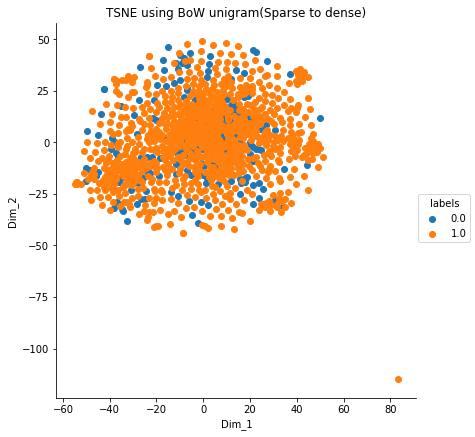

In [19]:
# Plotting TSNE by converting sparse BoW matrix to dense:
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_counts_dense[0:1000:]
#data_1000 = final_counts_svd[0:1000:]
#print (standardized_data.head)
label = final['Score']
labels = label[0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)
#print("passed")

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "labels"))
#print(tsne_df.head) 

# Ploting the result of tsne
sn.FacetGrid(tsne_df,hue = "labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE using BoW unigram(Sparse to dense)")
#plt.show()

In [ ]:
Applying Truncated SVD using 300/500/600 features and calculated explained variance ratio. Based upon high variance, 
concluded to use 600 features. 


In [20]:
#Applying Truncated SVD:
#choosing 300 features and calculating explained variance ration sum
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=300)
svd.fit(final_counts)  
TruncatedSVD(algorithm='randomized', n_components=300, n_iter=7,
        random_state=42, tol=0.0)
final_counts_svd = svd.fit(final_counts).transform(final_counts)
print(final_counts_svd.shape)
print(svd.explained_variance_ratio_.sum())

(4986, 300)
0.7266108383048321


In [ ]:
Observation:
    1.Explained variance ration sum is 0.72 for 300 features. Basically, we prefer data with high variance/huge spread. 

In [21]:
#Applying Truncated SVD:
#choosing 500 features and calculating explained variance ration sum
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=500)
svd.fit(final_counts)  
TruncatedSVD(algorithm='randomized', n_components=500, n_iter=7,
        random_state=42, tol=0.0)
final_counts_svd = svd.fit(final_counts).transform(final_counts)
print(final_counts_svd.shape)
print(svd.explained_variance_ratio_.sum())




(4986, 500)
0.8239251309463383


In [ ]:
Observation:
    By choosing 500 features, Variance ration sum is 0.82, which means, 82% of my data is widely spread.

In [22]:
#Applying Truncated SVD:
#choosing 600 features and calculating explained variance ration sum
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=600)
svd.fit(final_counts)
TruncatedSVD(algorithm='randomized', n_components=600, n_iter=7, tol=0.0)
final_counts_svd = svd.fit(final_counts).transform(final_counts)
print(final_counts_svd.shape)
print(svd.explained_variance_ratio_.sum())
##print(final_counts_svd[0:1:])



(4986, 600)
0.8547926187037


In [ ]:
Observation:
    From the above results, it can be said that 85% data is wide spread. Hence, finalizing 600 as number of components.

Text(0.5,1,'TSNE using BoW unigram(Truncated SVD)')

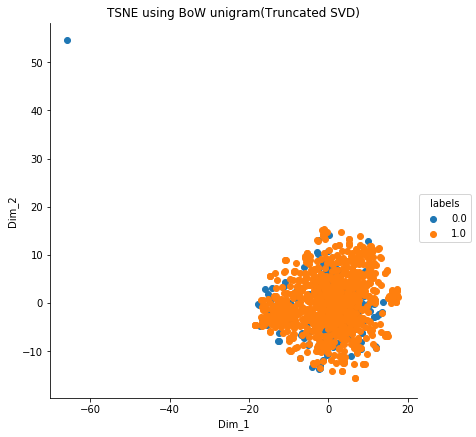

In [23]:
# Plotting TSNE after Truncated SVD dimensionality reduction
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
#data_1000 = final_counts_dense[0:1000:]
data_1000 = final_counts_svd[0:1000:]
#print (standardized_data.head)
label = final['Score']
labels = label[0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)
#print("passed")

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "labels"))
#print(tsne_df.head) 

# Ploting the result of tsne
sn.FacetGrid(tsne_df,hue = "labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE using BoW unigram(Truncated SVD)")
#plt.show()

In [24]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    print(final['Text'].head)
    print(final['Text'].shape)
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                    #print("First If condition Passed")
                    #if(cleaned_words.lower() not in stop):
                        #print("Word is not a stopword")
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        #print(s)
                        filtered_sentence.append(s)
                        # (final['Score'].values)[i] == 'positive': 
                        if (final['Score'].values)[i] == 1: 
                            #print("Positive word found")
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        #if(final['Score'].values)[i] == 'negative':
                        if(final['Score'].values)[i] == 0:
                            #print("Negative word found")
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    #else:
                        #continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #str1
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    #print(final['CleanedText'])
    #print(final.shape)
    #print(final.columns.values)

    
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', 
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

#print(all_positive_words)
#print(all_negative_words)

<bound method NDFrame.head of 0       Why is this $[...] when the same product is av...
1       We have used the Victor fly bait for 3 seasons...
2       I just received my shipment and could hardly w...
3       This was a really good idea and the final prod...
4       I'm glad my 45lb cocker/standard poodle puppy ...
5       We have been using this food for about 6 month...
6       I have nine cats and they are crazy about thes...
7       These were shipped out the day after I ordered...
8       This mix is probably not something you would w...
9       The description of this product is disceptive....
10      I bought this same brand from an online Indian...
11      I use these to keep my finicky toddler's prote...
12      When we get very busy in our home, I like this...
13      This company is an American Classic been in bu...
14      I love Pico Pica.  It adds some flavor, and it...
15      Thank goodness for MexGrocer. We love this Pic...
16      This is a very different sauce - n

100%|██████████| 4986/4986 [00:12<00:00, 405.57it/s]


In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
#print(final['CleanedText'].head)
#print(final_bigram_counts.values)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 127714)
the number of unique words including both unigrams and bigrams  127714


In [26]:
#Applying Truncated SVD:
#choosing 600 features and calculating explained variance ration sum
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
final_bigram_counts_svd = TruncatedSVD(n_components=600)
svd.fit(final_bigram_counts)
TruncatedSVD(algorithm='randomized', n_components=600, n_iter=7, tol=0.0)
final_bigram_counts_svd = svd.fit(final_bigram_counts).transform(final_bigram_counts)
print(final_bigram_counts_svd.shape)
print(svd.explained_variance_ratio_.sum())
##print(final_counts_svd[0:1:])

(4986, 600)
0.7056597312311603


In [ ]:
By choosing 600 features, 70% data is wide spread.

Text(0.5,1,'TSNE for bigram')

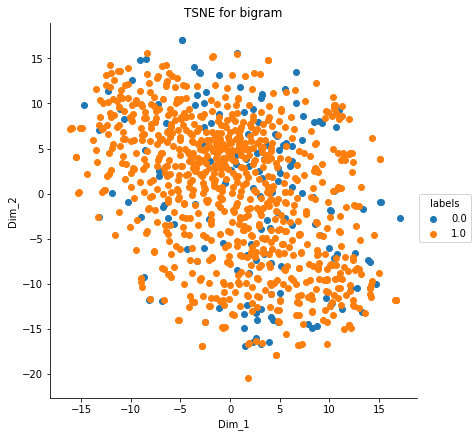

In [27]:
# TSNE for bigram
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
#data_1000 = final_counts_dense[0:1000:]
data_1000 = final_bigram_counts_svd[0:1000:]
#print (standardized_data.head)s
label = final['Score']
labels = label[0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)
#print("passed")

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "labels"))
#print(tsne_df.head) 

# Ploting the result of tsne
sn.FacetGrid(tsne_df,hue = "labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for bigram")
#plt.show()

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 148211)
the number of unique words including both unigrams and bigrams  148211


In [29]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[40000:40010])

some sample features(unique words in the corpus) ['each dried', 'each drink', 'each eat', 'each evening', 'each feeding', 'each fell', 'each five', 'each flavor', 'each for', 'each fortune']


In [30]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)
top_tfidf

,feature,tfidf
0,fly bait,0.274736
1,seasons can,0.274736
2,for seasons,0.274736
3,victor,0.262108
4,bait for,0.262108
5,the victor,0.262108
6,victor fly,0.262108
7,fly,0.246199
8,seasons,0.246199
9,bait,0.240521


In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [32]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

whi this when the same product avail for here www amazon com the victor and trap are unreal cours total fli genocid pretti stinki but onli right nearbi
*****************************************************************
['whi', 'this', 'when', 'the', 'same', 'product', 'avail', 'for', 'here', 'www', 'amazon', 'com', 'the', 'victor', 'and', 'trap', 'are', 'unreal', 'cours', 'total', 'fli', 'genocid', 'pretti', 'stinki', 'but', 'onli', 'right', 'nearbi']


In [33]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=5)

In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3037
sample words  ['whi', 'this', 'when', 'the', 'same', 'product', 'avail', 'for', 'here', 'www', 'amazon', 'com', 'and', 'trap', 'are', 'cours', 'total', 'fli', 'pretti', 'stinki', 'but', 'onli', 'right', 'nearbi', 'have', 'use', 'season', 'cant', 'beat', 'great', 'just', 'receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'love', 'which', 'what', 'call', 'them', 'instead', 'sticker', 'becaus', 'they', 'can', 'remov', 'easili', 'daughter']


In [35]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.9748965501785278),
 ('crunchi', 0.9655242562294006),
 ('textur', 0.955356240272522),
 ('crisp', 0.9509963393211365),
 ('light', 0.9495143294334412),
 ('salti', 0.9347854256629944),
 ('soft', 0.9323551654815674),
 ('low', 0.9311342239379883),
 ('chewi', 0.9231307506561279),
 ('crunch', 0.9196618795394897)]

In [36]:
w2v_model.wv.most_similar('like')

[('spici', 0.8856682777404785),
 ('realli', 0.8799726963043213),
 ('strong', 0.877139687538147),
 ('bitter', 0.871982216835022),
 ('tast', 0.8707834482192993),
 ('doe', 0.8631897568702698),
 ('not', 0.8614490032196045),
 ('doesnt', 0.8605141043663025),
 ('smell', 0.8525605201721191),
 ('real', 0.8513809442520142)]

In [ ]:
Above result shows few dissimilar words for like, which may be due to less number of data points chosen as an input

In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:05<00:00, 834.50it/s]


4986
50


In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:08<00:00, 556.82it/s]


Text(0.5,1,'TSNE for TF-IDF weighted Word2Vec')

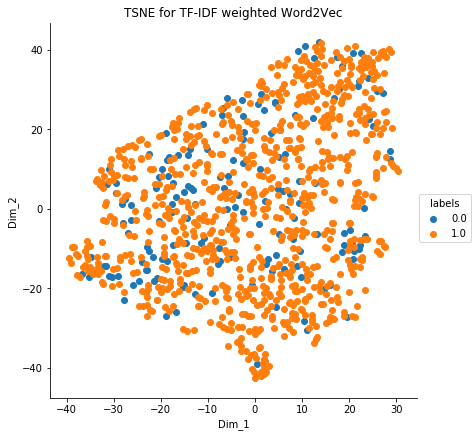

In [40]:
# TSNE for TF-IDF weighted Word2Vec
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
#data_1000 = final_counts_dense[0:1000:]
data_1000 = tfidf_sent_vectors[0:1000:]
#print (standardized_data.head)s
label = final['Score']
labels = label[0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)
#print("passed")

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "labels"))
#print(tsne_df.head) 

# Ploting the result of tsne
sn.FacetGrid(tsne_df,hue = "labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TF-IDF weighted Word2Vec")
#plt.show()

Text(0.5,1,'TSNE using Average W2V model')

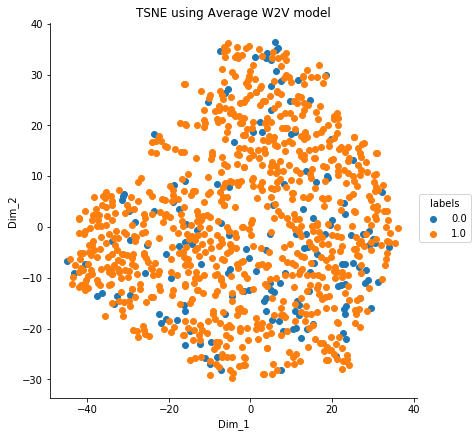

In [41]:
# TSNE for average W2V 
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
#data_1000 = final_counts_dense[0:1000:]
data_1000 = sent_vectors[0:1000:]
#print (standardized_data.head)s
label = final['Score']
labels = label[0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)
#print("passed")

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "labels"))
#print(tsne_df.head) 

# Ploting the result of tsne
sn.FacetGrid(tsne_df,hue = "labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE using Average W2V model")
#plt.show()

In [ ]:
Upon applying TSNE using BoW, bigram, Average W2V and TFIDG weighted W2V techniques, both positive and negative reviews are 
overlapping. The reviews cannot be visualized into two separate clusters.